In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import yaml
import torch 
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# from pyt_ex import neural_net.Ann as ann 
from tqdm import tqdm

Input_Matrix = pd.read_excel('Data/as of 2020 Historical Data.xlsx', sheet_name='Input Matrix')

Target_Matrix = pd.read_excel('/home/sai/Pyt-Ex/Data/as of 2020 Historical Data.xlsx', sheet_name='Target Matrix')


In [3]:
from pyt_ex import Ann as neural_network 
from pyt_ex import ClassifierDataset, FastTensorDataLoader 

In [4]:
Input_Matrix

,Unnamed: 0,Unnamed: 1,Inputs (at Landfall),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,First Landfall Location,Unnamed: 8,Second Landfall Location,Unnamed: 10,Third Landfall Location,Unnamed: 12,Fourth Landfall Location,Unnamed: 14
0,Year,Storm,Population Affected,Pressure (mbar),Wind Speed (mph),Storm Surge (ft),Precip (inches),Latitude,Longtitude,Latitude,Longtitude,Latitude,Longtitude,Latitude,Longtitude
1,2020,Bertha,710000,1005,51.75,1.32,15,32.9,79.7,0,0,0,0,0,0
2,NaN,Cristobal,7200000,990,51.75,6.2,13.65,29.3,89.8,0,0,0,0,0,0
3,NaN,Fay,22500000,999,51.75,2.67,6.97,39.4,74.4,0,0,0,0,0,0
4,NaN,Hanna,2000000,973,92,6.24,15.49,26.8,97.3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,NaN,H. Earl,1600000,987,80.5,5.3,16.38,30.1,85.7,0,0,0,0,0,0
93,NaN,TS. Frances,17000000,990,51.75,5.1,11.38,28.2,96.9,0,0,0,0,0,0
94,NaN,H. Georges,11200000,964,103.5,9,38.46,24.5,81.8,30.4,88.9,0,0,0,0
95,NaN,TS. Hermine,2200000,1000,40.25,0,1,29.1,90.9,0,0,0,0,0,0


In [5]:
target_columns = ['Year', 'Storm', 'Ry_Damage', '2016_USD', 'Impact_Level', 'IL0', 'IL1', 'IL2', 'IL3', 'IL4', 'IL5', 'Check']

Target_Matrix.drop(['Unnamed: 11', 'Unnamed: 13'], axis=1, inplace=True)

Target_Matrix.set_axis(target_columns, axis=1, inplace=True)

# Target_Matrix

In [6]:
input_columns = ['Year', 'Storm', 'Population_Affected', 'Pressure(mbar)', 'Wind_Speed(mph)', 'Storm_Surge(ft)', 'Precip(inches)', 'First_Latitude', 'First_Longtitude', 'Second_Latitude', 'Second_Longtitude', 'Third_Latitude', 'Third_Longtitude', 'Fourth_Latitude', 'Fourth_Longtitude']

Input_Matrix.set_axis(input_columns, axis=1, inplace=True)

Input_Matrix.drop([0], inplace = True)

Input_Matrix.reset_index(drop=True, inplace=True)

Input_Matrix.drop(['Year', 'Storm'], axis=1, inplace=True)

# Input_Matrix

df = Input_Matrix
df['Impact_Level'] = Target_Matrix['Impact_Level'] 


<AxesSubplot:xlabel='Impact_Level', ylabel='count'>

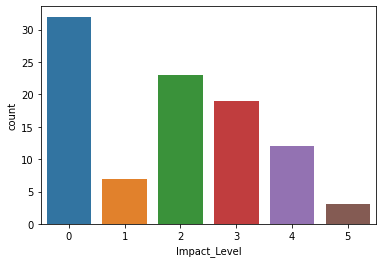

In [7]:
sns.countplot(x = 'Impact_Level', data=df) 

In [8]:
class ClassifierDataset(Dataset):
    '''
    to set data in a block.
    this dataset will be used by the dataloader to pass the data
    into the model.
    X = float
    y = long
    '''
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "rating_0": 0,
        "rating_1": 0,
        "rating_2": 0,
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_0'] += 1
        elif i == 1: 
            count_dict['rating_1'] += 1
        elif i == 2: 
            count_dict['rating_2'] += 1
        elif i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1  
        elif i == 5: 
            count_dict['rating_5'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

In [17]:
logger = {}
seeds = [2, 3, 7, 11, 13, 17, 19, 23, 29, 31]

device = 'cpu'#torch.device("cuda" if torch.cuda.is_available() else "cpu")  
torch.manual_seed(10) 

with open('config/Input.yaml') as File:
    dic = yaml.load(File, Loader=yaml.FullLoader)

for i in tqdm(dic):
    logger[i] = {}

    batch_size = dic[i]["batch_size"]
    for j in seeds:
        # print(i)
        X = df.iloc[:, 0:-1]
        y = df.iloc[:, -1]

        # Split into train+val and test
        X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=j)

        # Split train into train-val
        X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=j)

        scaler = MinMaxScaler()

        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        X_train, y_train = np.array(X_train), np.array(y_train)
        X_val, y_val = np.array(X_val), np.array(y_val)
        X_test, y_test = np.array(X_test), np.array(y_test)

        X = np.array(scaler.transform(X))
        y = np.array(y)

        # train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
        # val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
        # test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())
        # dataset = ClassifierDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())

        # target_list = []
        # for _, t in train_dataset:
        #     target_list.append(t)
            
        # target_list = torch.tensor(target_list)
        # target_list = target_list[torch.randperm(len(target_list))] 

        # class_count = [i for i in get_class_distribution(y_train).values()]
        # class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

        # class_weights_all = class_weights[target_list]

        # weighted_sampler = WeightedRandomSampler(
        #     weights=class_weights_all,
        #     num_samples=len(class_weights_all),
        #     replacement=True
        # )

        # train_loader = FastTensorDataLoader(dataset=train_dataset,
        #                     batch_size=batch_size,
        #                     sampler=weighted_sampler
        #                         )

        # val_loader = FastTensorDataLoader(dataset=val_dataset, batch_size=batch_size)
        # test_loader = FastTensorDataLoader(dataset=test_dataset, batch_size=batch_size) 
        # full_loader = FastTensorDataLoader(dataset=dataset)

        train_loader = FastTensorDataLoader(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long(), batch_size=batch_size)

        val_loader = FastTensorDataLoader(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long(), batch_size=batch_size)
        test_loader = FastTensorDataLoader(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long(), batch_size=batch_size) 
        full_loader = FastTensorDataLoader(torch.from_numpy(X).float(), torch.from_numpy(y).long())

        ann = neural_network.Ann(dic[i])
        ann = ann.to(device)
        ann.fit(train_dataloader=train_loader, 
                    val_dataloader=val_loader, 
                    test_dataloader=test_loader, 
                    full_dataloader=full_loader ) 
        # unique = [0, 1, 2, 3, 4, 5]
        # if ann.final_acc*100 >= 70:
        logger[i][j] = {}
        logger[i][j]['y_test'] = y_test
        logger[i][j]["train_acc_list"] = ann.train_acc_list
        logger[i][j]["val_acc_list"] = ann.val_acc_list
        logger[i][j]["train_loss_list"] = ann.train_loss_list
        logger[i][j]["val_loss_list"] = ann.val_loss_list
        logger[i][j]["test_output"] = ann.test_Output
        logger[i][j]["test_acc"] = ann.test_acc
        logger[i][j]["Predictions"], logger[i][j]['Final_acc'] = ann.predictions, ann.final_acc
        logger[i][j]['classification_report'] = classification_report(y_test, ann.test_Output, labels = unique)

100%|██████████| 1/1 [01:28<00:00, 88.57s/it]


In [19]:
for i in seeds:
    print(logger[1][i]['Final_acc'])

0.22916666666666666
0.4479166666666667
0.3333333333333333
0.4479166666666667
0.2708333333333333
0.3645833333333333
0.3645833333333333
0.4270833333333333
0.5520833333333334
0.4895833333333333


In [10]:
print(logger['TWO'][2]['Final_acc'])  

KeyError: 'TWO'

In [ ]:
s = list(logger['TWO'].keys())
l = []
for i in s:
    l.append(logger['TWO'][i]['Final_acc'])
l 

[0.7604166666666666,
 0.7916666666666666,
 0.7916666666666666,
 0.84375,
 0.7604166666666666,
 0.8020833333333334,
 0.7708333333333334,
 0.7291666666666666,
 0.7395833333333334]

In [ ]:
s = list(logger['TWO'].keys())
t = []
for i in s:
    t.append(logger['TWO'][i]['test_acc'])
t 

[0.55, 0.45, 0.4, 0.7, 0.45, 0.6, 0.55, 0.4, 0.45]

In [ ]:
import torchbnn as bnn
from torch import nn

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=15, out_features=50),
    nn.Tanh(),
    nn.BatchNorm1d(50),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=50, out_features=2)
) 

In [ ]:
# def model_plots(i):
#     from matplotlib.gridspec import GridSpec
#     fig = plt.figure(figsize=(20, 10))
#     gs = GridSpec(nrows=2, ncols=2)

#     ax0 = fig.add_subplot(gs[0, 0])
#     ax0.plot(plots[i]["train_acc_list"], label = 'train_acc_list')
#     ax0.plot(plots[i]["val_acc_list"], label = 'val_acc_list')
#     ax0.legend()
#     ax0.title.set_text('Training and validation accuracy')
#     ax0.set(xlabel='Iterations', ylabel='Accuracy')

#     ax1 = fig.add_subplot(gs[0, 1])
#     ax1.plot(plots[i]["train_loss_list"], label = 'train_loss_list')
#     ax1.plot(plots[i]["val_loss_list"], label = 'val_loss_list')
#     ax1.legend() 
#     ax1.title.set_text('Training and validation loss')
#     ax1.set(xlabel='Iterations', ylabel='CrossEntropyLoss')

#     ax2 = fig.add_subplot(gs[1, 0])
#     confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, plots[i]["test_output"]))
#     ax2 = sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues')
#     ax2.title.set_text('Test Confusion matrix')
#     ax2.set(xlabel='Predicted Label', ylabel='True Label')

#     # ax3 = fig.add_subplot()
#     ax3 = fig.add_subplot(gs[1, 1])
#     confusion_matrix_df = pd.DataFrame(confusion_matrix(y, plots[i]["Predictions"]))
#     ax3 = sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues')
#     ax3.title.set_text('Full Confusion matrix, final_acc = '+str( plots[i]['Final_acc']))
#     ax3.set(xlabel='Predicted Label', ylabel='True Label')

#     plt.show()

# models = [i for i in plots.keys()]
# models


In [ ]:
import torch.optim as optim
from ray import tune
from ray.tune.examples.mnist_pytorch import get_data_loaders, ConvNet, train, test


def train_mnist(config):
    train_loader, test_loader = get_data_loaders()
    model = ConvNet()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"])
    for i in range(10):
        train(model, optimizer, train_loader)
        acc = test(model, test_loader)
        # tune.report(mean_accuracy=acc)


analysis = tune.run(
    train_mnist, config={"lr": tune.grid_search([0.001, 0.01, 0.1])})

# print("Best config: ", analysis.get_best_config(metric="mean_accuracy"))

# Get a dataframe for analyzing trial results.
df = analysis.dataframe()

Trial name,status,loc,lr
train_mnist_dfda9_00000,PENDING,,0.001
train_mnist_dfda9_00001,PENDING,,0.01
train_mnist_dfda9_00002,PENDING,,0.1


(raylet) /home/sai/.local/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)
(raylet) /home/sai/.local/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)
(raylet) /home/sai/.local/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)
(raylet) /home/sai/.local/lib/python3.8/site-packages/redis/connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(raylet)   warnings.warn(msg)
(pid=1172) /home/sai/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable.

Trial train_mnist_dfda9_00001 completed. Last result: 
Trial train_mnist_dfda9_00000 completed. Last result: 
Trial train_mnist_dfda9_00002 completed. Last result: 


Trial name,status,loc,lr
train_mnist_dfda9_00000,TERMINATED,172.28.228.115:1174,0.001
train_mnist_dfda9_00001,TERMINATED,172.28.228.115:1172,0.01
train_mnist_dfda9_00002,TERMINATED,172.28.228.115:1173,0.1


2021-11-15 19:33:57,762	INFO tune.py:630 -- Total run time: 5.03 seconds (4.90 seconds for the tuning loop).


In [ ]:
df

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,config/lr,logdir
0,0.209375,0.282337,False,NaN,NaN,10,3db57_00000,4b361979e5384f7c9fa25fd3ce9cc569,2021-11-15_19-29-24,1637022564,2.721422,805,DESKTOP-3CVVCKA,172.28.228.115,2.721422,0,10,0.001,/home/sai/ray_results/train_mnist_2021-11-15_1...
1,0.796875,0.304014,False,NaN,NaN,10,3db57_00001,dcc4a581f1644dc7a7c5d79479a48dff,2021-11-15_19-29-26,1637022566,2.914158,808,DESKTOP-3CVVCKA,172.28.228.115,2.914158,0,10,0.010,/home/sai/ray_results/train_mnist_2021-11-15_1...
2,0.865625,0.301122,False,NaN,NaN,10,3db57_00002,c3817e5a42d34d1398f7cc77e633521f,2021-11-15_19-29-26,1637022566,2.997246,809,DESKTOP-3CVVCKA,172.28.228.115,2.997246,0,10,0.100,/home/sai/ray_results/train_mnist_2021-11-15_1...
